In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
import sys
print(sys.version)

3.8.5 (default, Sep  3 2020, 21:29:08) [MSC v.1916 64 bit (AMD64)]


In [3]:
import numpy as np
import pandas as pd
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import datetime
import os
import torchvision
import time
import copy
from torch.utils.tensorboard import SummaryWriter

In [4]:
torch.__version__

'1.7.1+cu110'

In [5]:
from torchvision.datasets import CIFAR100
from torch.utils.data import DataLoader

In [6]:
train_transform = transforms.Compose([transforms.ToTensor(), transforms.Resize(size=(227, 227))])
valid_transform = train_transform

In [7]:
train_set = CIFAR100('./data/cifar100', train=True,
                  download=True, transform=train_transform)
valid_set = CIFAR100('./data/cifar100', train=False,
                  download=True, transform=valid_transform)

Files already downloaded and verified
Files already downloaded and verified


In [8]:
train_loader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(valid_set, batch_size=128, shuffle=False)

In [9]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        
        self.layer1 = nn.Conv2d(in_channels = 3, out_channels = 64, kernel_size = 5,
                                stride = 2, padding = 2)
        self.layer2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 5, 
                               stride = 2, padding = 2)
        self.layer3 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 5, 
                               stride = 2, padding = 2)
        self.mxpool = nn.MaxPool2d(2, 2)
        self.mxpool1 = nn.MaxPool2d(2, 2, padding = 1)
        self.relu = nn.ReLU() # not used # instead used relu from Functional 'F' directly
        self.linear1 = nn.Linear(4096, 1024)
        self.linear2 = nn.Linear(1024, 1024)
        self.linear3 = nn.Linear(1024, 100)
        
    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.mxpool(x)
        x = F.relu(self.layer2(x))
        x = self.mxpool1(x)
        x = F.relu(self.layer3(x))
        x = self.mxpool(x)
        
        x = x.reshape(x.shape[0], -1)
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        x = self.linear3(x) # using nn.CrossEntropy() that combines nn.LogSoftmax() and nn.NLLLoss() in one single class
        return x

In [10]:
device = 'cuda'
model = SimpleNet()
model.to(device)

SimpleNet(
  (layer1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (layer2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (layer3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (mxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (mxpool1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear1): Linear(in_features=4096, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=100, bias=True)
)

In [11]:
from torchsummary import summary
input_shape = (3, 227, 227)
summary(model, input_shape)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 114, 114]           4,864
         MaxPool2d-2           [-1, 64, 57, 57]               0
            Conv2d-3          [-1, 128, 29, 29]         204,928
         MaxPool2d-4          [-1, 128, 15, 15]               0
            Conv2d-5            [-1, 256, 8, 8]         819,456
         MaxPool2d-6            [-1, 256, 4, 4]               0
            Linear-7                 [-1, 1024]       4,195,328
            Linear-8                 [-1, 1024]       1,049,600
            Linear-9                  [-1, 100]         102,500
Total params: 6,376,676
Trainable params: 6,376,676
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.59
Forward/backward pass size (MB): 9.15
Params size (MB): 24.33
Estimated Total Size (MB): 34.06
-------------------------------------

In [12]:
for imgs, target in train_set:
    print(imgs.shape)
    print(target)
    break

torch.Size([3, 227, 227])
19


In [13]:
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, nesterov=True)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer,'min')
loss_fn = nn.CrossEntropyLoss()

In [14]:
# Initialize the weights of layers.
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

In [15]:
model.apply(init_weights)

SimpleNet(
  (layer1): Conv2d(3, 64, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (layer2): Conv2d(64, 128, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (layer3): Conv2d(128, 256, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
  (mxpool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (mxpool1): MaxPool2d(kernel_size=2, stride=2, padding=1, dilation=1, ceil_mode=False)
  (relu): ReLU()
  (linear1): Linear(in_features=4096, out_features=1024, bias=True)
  (linear2): Linear(in_features=1024, out_features=1024, bias=True)
  (linear3): Linear(in_features=1024, out_features=100, bias=True)
)

In [16]:
def train_model(model, dataloaders, criterion, optimizer, num_epochs=25):
    since = time.time()

    val_acc_history, val_loss_history = [], []
    train_acc_history, train_loss_history = [], []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    loss_train = 0.0

    for epoch in range(1, num_epochs + 1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        loss_train += loss.item()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            
            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
            if phase == 'val':
                val_acc_history.append(epoch_acc)
                val_loss_history.append(epoch_loss)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                train_loss_history.append(epoch_loss)
                
        # decreasing learning rate with the epochs
        scheduler.step(loss_train)
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, val_loss_history, train_acc_history, train_loss_history 

In [17]:
dataloaders_dict = {'train': train_loader, 'val': val_loader}
num_epochs = 10

model_fit, val_acc_hist, val_loss_hist, train_acc_hist, train_loss_hist = train_model(model,
                                                                                      dataloaders_dict,
                                                                                      loss_fn,
                                                                                      optimizer,
                                                                                      num_epochs)

Epoch 1/10
----------
train Loss: 4.1276 Acc: 0.0734
val Loss: 3.8129 Acc: 0.1176

Epoch 2/10
----------
train Loss: 3.4300 Acc: 0.1824
val Loss: 3.2223 Acc: 0.2164

Epoch 3/10
----------
train Loss: 2.9727 Acc: 0.2648
val Loss: 2.9602 Acc: 0.2694

Epoch 4/10
----------
train Loss: 2.6263 Acc: 0.3359
val Loss: 2.7138 Acc: 0.3199

Epoch 5/10
----------
train Loss: 2.3217 Acc: 0.3965
val Loss: 2.5907 Acc: 0.3551

Epoch 6/10
----------
train Loss: 2.0301 Acc: 0.4614
val Loss: 2.5282 Acc: 0.3717

Epoch 7/10
----------
train Loss: 1.7291 Acc: 0.5312
val Loss: 2.5179 Acc: 0.3870

Epoch 8/10
----------
train Loss: 1.4091 Acc: 0.6084
val Loss: 2.6330 Acc: 0.3815

Epoch 9/10
----------
train Loss: 1.0834 Acc: 0.6876
val Loss: 2.8996 Acc: 0.3888

Epoch 10/10
----------
train Loss: 0.7972 Acc: 0.7614
val Loss: 3.2814 Acc: 0.3697

Training complete in 9m 56s
Best val Acc: 0.388800


In [21]:
v_loss = [v for v in val_loss_hist]
t_loss = [t for t in train_loss_hist]

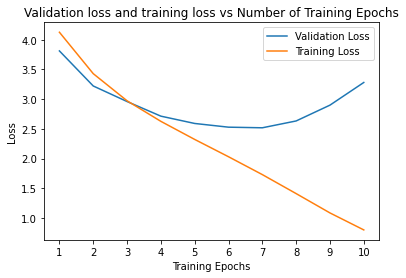

In [22]:
plt.title("Validation loss and training loss vs Number of Training Epochs")
plt.xlabel("Training Epochs")
plt.ylabel("Loss")
plt.plot(range(1, num_epochs+1), v_loss, label="Validation Loss")
plt.plot(range(1, num_epochs+1), t_loss, label="Training Loss")
# plt.ylim((0,1.))
plt.xticks(np.arange(1, num_epochs+1, 1.0))
plt.legend()
plt.show()

In [20]:
# validate the training on validation set
def validate(model, train_loader, val_loader):
    for name, loader in [('train', train_loader), ('val', val_loader)]:
        correct = 0
        total = 0
        print(name)
        print(loader)
        with torch.no_grad():
            for imgs, labels in loader:
                imgs = imgs.to(device=device)
                labels = labels.to(device=device)
                
                y = model(imgs)
                _, predicted = torch.max(y, dim=1)
                total += labels.shape[0]
                correct += int((predicted == labels).sum())
        print("Accuracy {}: {:.2f}".format(name, correct/total))
        print("{}: correct, total = {},{}".format(name, correct, total))

In [22]:
validate(model, train_loader, val_loader)

train
Accuracy train: 0.66
train: correct, total = 32995,50000
val
Accuracy val: 0.37
val: correct, total = 3707,10000
